# Forest and Fires Project

Forest fires have remained ever present of an issue often costing billions of dollars every year in damages. With wildfires headling the news seemingly every other year with the 2020 California Wildfire season, the 2023 Hawaii Wildfires, and even the 2013 Yarnell Hill Wildfire which killed 19 firefighters and was the inspiration for the movie "Only the Brave", I was interested to find out the true scale of these forest fires and their contribution to deforestation; at the very least inside of the United States. 

With climate change causing an increase in the dangers of wildfires, I wanted to look at these forest fires on the scale as a nation and determine the role they played in deforestation and just how serious the rise in wildfires were. I found that while there has been a noticeable rise in the number of forest fires since the early 2000's this increase was largely due to an increase in controlled fires whose effect is still to be seen. Overall forest area trends around the world vary by region and country but some conclusions can be made about the cause of deforestation as a whole.

In [1]:
# First we import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
from rasterio.plot import show
import rasterio.mask

from rasterio.warp import calculate_default_transform, reproject, Resampling

import contextily as ctx

C:\Users\Brodie\AppData\Local\Temp\ipykernel_17256\465160076.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
# States for the boundaries
url_county = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_500k.zip'
state_gdf = gpd.read_file(url_county)


#Exclude everthing outside the contiguous US:
exclude_list = [15, 72, 2, 60, 66, 69, 78]
state_gdf = state_gdf.loc[~state_gdf['STATEFP'].astype(int).isin(exclude_list)]

state_gdf = state_gdf.to_crs(5070)

After loading the state data from past labs, I went on to the website of Monitoring Trends in Burn Severity (https://www.mtbs.gov/direct-download) and downloaded the geometries of the wildfires in the past ~40 years since 1985.

In [4]:
fire_file = r"C:\Users\Brodie\Downloads\mtbs_perimeter_data\mtbs_perims_DD.shp"

fire_gdf = gpd.read_file(fire_file)

fire_gdf

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,AK6448214467319840607,None,GLACIER CREEK,Wildfire,4534,MTBS,Initial (SS),1897,64.482,-144.673,...,506601519860705,-9999,-9999,9999,9999,550,165,-20,None,"POLYGON ((-144.67866 64.49452, -144.67802 64.4..."
1,SD4308410285019840906,None,SANDOZ,Wildfire,4535,MTBS,Initial,2691,43.084,-102.850,...,None,211,-9999,-970,-150,220,700,9999,None,"POLYGON ((-102.84037 43.07562, -102.84089 43.0..."
2,MT4880411345819840819,None,NAPI PEAK,Wildfire,4536,MTBS,Extended,3680,48.804,-113.458,...,None,-62,-9999,-970,-150,160,308,515,None,"POLYGON ((-113.48150 48.80303, -113.48122 48.8..."
3,MT4533610695819840826,None,KIRBY,Wildfire,4537,MTBS,Extended,1597,45.336,-106.958,...,None,52,-9999,-970,-150,150,309,525,None,"POLYGON ((-106.93270 45.33398, -106.93237 45.3..."
4,MT4561710632319840918,None,LAKE CREEK,Wildfire,4538,MTBS,Initial,3617,45.617,-106.323,...,None,-104,-9999,-970,-150,-50,175,9999,None,"POLYGON ((-106.32656 45.63166, -106.32635 45.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30919,FL2587108124920220306,None,OCHOPEE RX UNIT C (DR311),Prescribed Fire,10024901,MTBS,Initial,2500,25.868,-81.257,...,None,-33,27,-970,-150,0,9999,9999,None,"POLYGON ((-81.23649 25.87059, -81.23661 25.870..."
30920,FL3027208471520220201,None,UNNAMED,Prescribed Fire,10024910,MTBS,Initial,1071,30.266,-84.701,...,None,48,38,-970,-150,100,350,9999,None,"POLYGON ((-84.71347 30.28559, -84.70921 30.285..."
30921,FL3043308448820220301,None,UNNAMED,Prescribed Fire,10024914,MTBS,Initial,2106,30.43,-84.491,...,None,34,22,-970,-150,80,400,9999,Burn scar to the east is under a different ID.,"POLYGON ((-84.52515 30.41831, -84.52518 30.418..."
30922,AL3111908654520220504,EDF9CE76-7A31-4BA4-BD95-5DB4BA8605BE,CN BLUE SPRINGS EAST 17,Prescribed Fire,10024915,MTBS,Initial,1887,31.124,-86.547,...,None,-68,26,-970,-150,-53,485,9999,None,"POLYGON ((-86.55296 31.11455, -86.55429 31.114..."


# MTBS Fire - Documentation

Now the exact language of the document was foreign to me so I went about trying to determine the meaning of many of the column names.

- Event_ID: unique identifier for each forest fire event
- irwinID: Integrated Reporting of Wildland-Fire Information - ID used within the IRWIN system which is largely irrlevant to me
- Incid_Name: Name of the incident
- Incid_Type: Type of incident
- Map_ID: Identifier of the mapping system
- Map_Prog: Mapping program(?)
- Asmnt_Type: Assessment Type - kind of evaluation being reported
- BurnBndAc: Burned Boundary Acres - indicating the total acres burned
- BurnBndLat: Latitude coordinate for the burned area boundary (centroid)
- BurnBndLon: Longitude coordinate for the burned area boundary (centroid)
- Ig_Date: Ignition Date
- Pre_ID: PreAssessment ID - risk assessment or fire prevention
- Post_ID: Post-Assessment ID - assessments made after for damages
- Perim_ID: Perimiter ID, unique indentifier for fire's perimeter data
- dNBR_offst: Difference Normalized Burn Ratio is an index designed to highlight burn areas in large fires 
- ndBR__stdDev: Standard Deviation of the differenced Normalized Burn Ratio providing measure of variability  
- NoData_T: Threshold for No Data values
- IncGreen_T: Incremental Green Threshold - vegetation recovery of presence of - live, unburned vegetation within burned area
- Low_T: Low Threshold - potentially indicating a lower boundary for certain measurements or assessments such as low severity burn areas
- Mod_T: Moderate Threshold - same but for moderate burn areas
- High_T: High Threshold - same for high burn areas



In [5]:
fire_gdf = fire_gdf.to_crs(epsg=5070)

In [6]:
# Converting to date for easier usage
fire_gdf['Ig_Date'] = pd.to_datetime(fire_gdf['Ig_Date'])

fire_gdf['Ig_Date']

0       1984-06-07
1       1984-09-06
2       1984-08-19
3       1984-08-26
4       1984-09-18
           ...    
30919   2022-03-06
30920   2022-02-01
30921   2022-03-01
30922   2022-05-04
30923   2022-08-24
Name: Ig_Date, Length: 30924, dtype: datetime64[ns]

## Incident Types

The first variable to look at was Incident Types. This was purely exploratory at first but would become much more important later on. 

The four variables were: Wildfires, Prescribed Fires, Wildland Fire Use, and Unknown.

Wildfires were the standard unplanned forest fires caused by either some lightning strikes, arson, accident, or otherwise.

Prescribed Fires are fires set with the express purpose of clearing out debris and lessening the harm that future wildfires might cause. In nature, natural wildfires were able to clear low-growing flora which could free up land and resources for trees and other organisms. The semi-regular nature of these natural wildfires would act as a way of keeping the debris like fallen logs or dried leaves at the bottom of the forest floor from overcrowding and building up as fuel for larger fires. However as civilizations grew and industrialized, we tried to put a stop to natural wildfires as they could kill or destroy property on such large scales like the infamous Great Fire of London. This helped put a bandaid solution on the issue but as natural forest fires grew more infrequent, the debris and fuel would build up at the forest floor. This would cause any fires that did spread to rampage due to the large amounts of fuel that they now had. Prescribed fires eventually became a way of humanity's attempt to self-regulate the fires back to a cleanup method for the forest. They're largely used today to keep potential natural wildfires' damages to a minimum.

Wildland Fire Use is for very specific burns carried out for very specific uses other than the health of the forest.

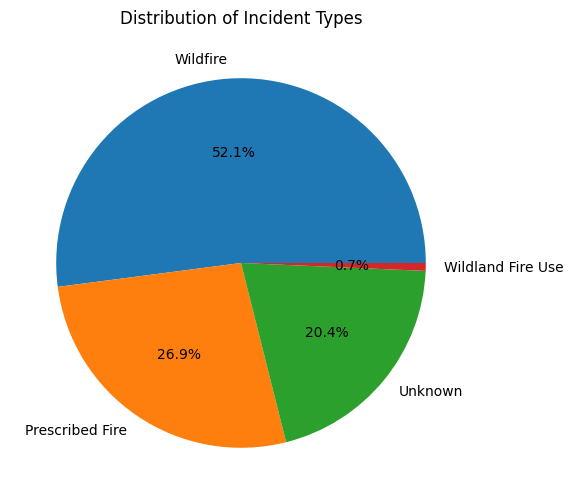

In [7]:
incid_counts = fire_gdf['Incid_Type'].value_counts()

color_fires = {
    'Wildfire': 'red',
    'Prescribed Fire': 'blue',
    'Wildland Fire Use': 'green',
    'Unknown': 'purple'
}

plt.figure(figsize=(10, 6))
incid_counts.plot(kind='pie', labels=incid_counts.index, autopct='%1.1f%%', color = color_fires)
plt.ylabel('')
plt.title('Distribution of Incident Types')
plt.show()

We see that wildfires made up the majority of fires at 52.1% but a large portion of the pie chart came from Prescribed Fire. I was interested to see how common the prescribed fires were compared to regular wildfires as it came in at 26.9% of all forest fires in the area.

## Burn Severity By Year
Next was to see some overall trends of the burn severity when it came to how many acres would have been burned every year. I wanted to see if there was any relationship with the rise in temperatrues and the rates of forest fires.

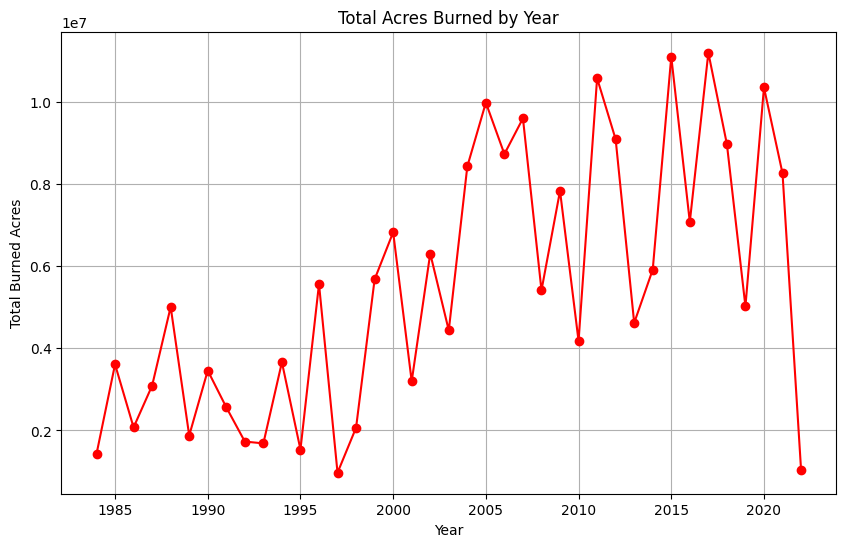

In [8]:
fire_gdf['Year'] = fire_gdf['Ig_Date'].dt.year

yearly_burned_acres = fire_gdf.groupby('Year')['BurnBndAc'].sum()

plt.figure(figsize=(10, 6))
yearly_burned_acres.plot(kind='line', marker='o', linestyle='-', color='red')
plt.title('Total Acres Burned by Year')
plt.xlabel('Year')
plt.ylabel('Total Burned Acres')
plt.grid(True)
plt.show()

The first graph looked promising showing an overall trend upwards over time with later years experiencing more acres burned for each year. However I wanted to test it against the number of fires in each year as a proportion.

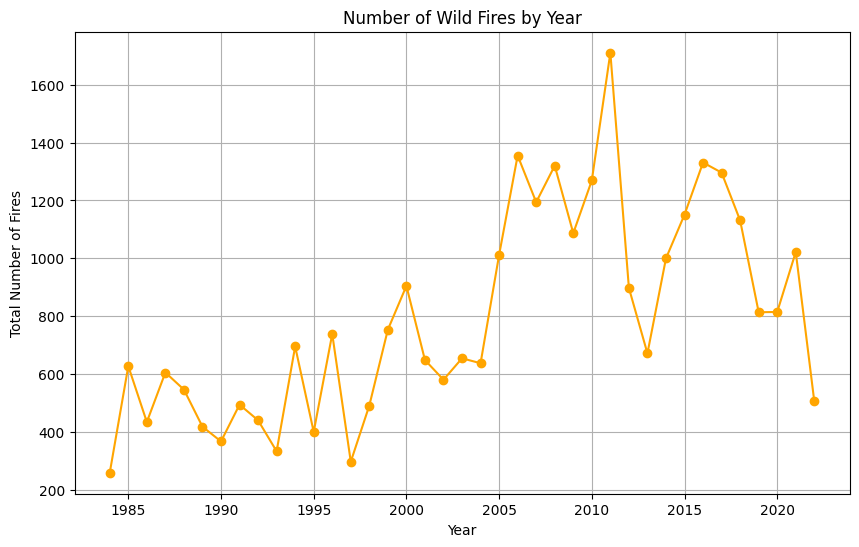

In [9]:
# Total number of wildfires each year

yearly_fires = fire_gdf.groupby('Year')['Event_ID'].count()

plt.figure(figsize=(10, 6))
yearly_fires.plot(kind='line', marker='o', linestyle='-', color='orange')
plt.title('Number of Wild Fires by Year')
plt.xlabel('Year')
plt.ylabel('Total Number of Fires')
plt.grid(True)
plt.show()

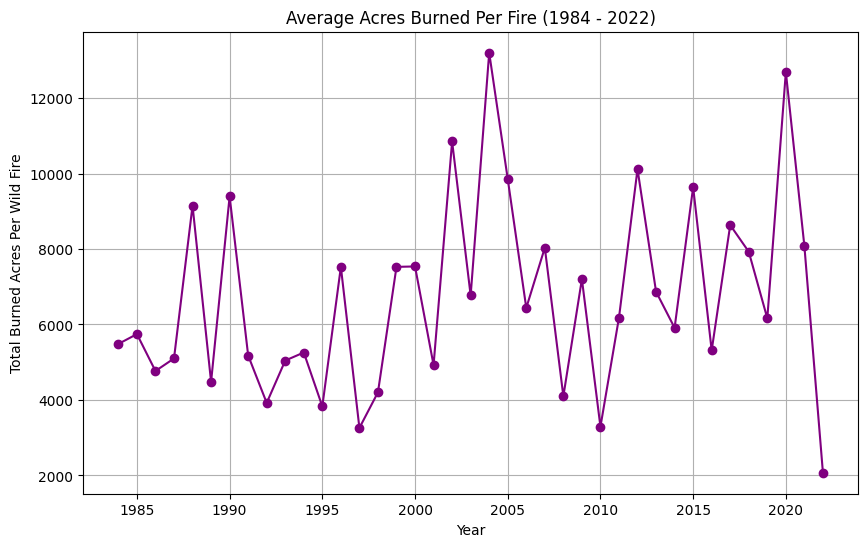

In [10]:
# Average number of acres burned every year

average_acreage = yearly_burned_acres / yearly_fires

plt.figure(figsize=(10, 6))
average_acreage.plot(kind='line', marker='o', linestyle='-', color='purple')
plt.title('Average Acres Burned Per Fire (1984 - 2022)')
plt.xlabel('Year')
plt.ylabel('Total Burned Acres Per Wild Fire')
plt.grid(True)
plt.show()

Graphing the average amount of acres burned for each fire showed no significant trends other than the odd spikes at 2004, 2020 (likely due to the California fires), and then 2022 which we've seen to be a slow year in terms of fires.

I still wanted to check if there could be a linear regression model based around the year and the number of acres burned so I tried to make a very simple regression model.

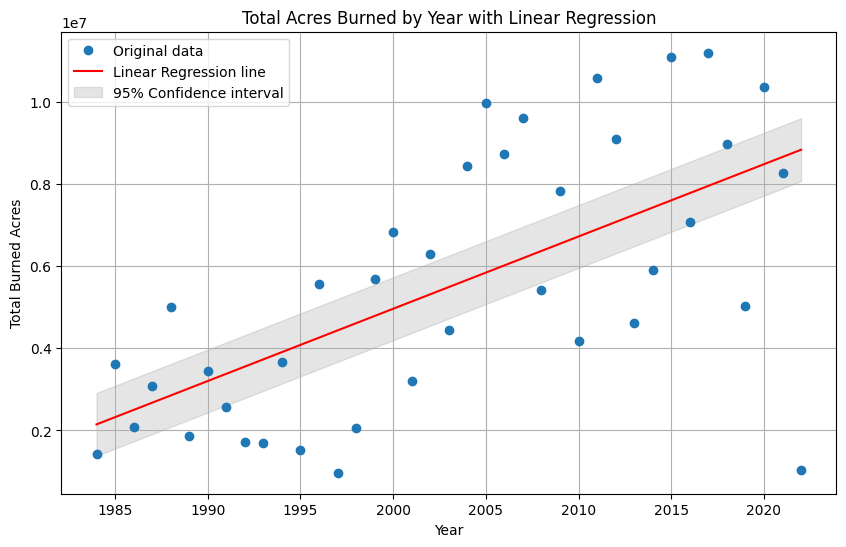

In [11]:
X = yearly_burned_acres.index.values.reshape(-1, 1)
y = yearly_burned_acres.values

model = LinearRegression()
model.fit(X, y)

y_hat = model.predict(X)

stderr = np.sqrt(mean_squared_error(y, y_hat) / len(X))
ci = 1.96 * stderr

lower_bound = y_hat - ci
upper_bound = y_hat + ci

plt.figure(figsize=(10, 6))
plt.plot(X, y, 'o', label='Original data')
plt.plot(X, y_hat, 'r', label='Linear Regression line')
plt.fill_between(X.flatten(), lower_bound, upper_bound, color='grey', alpha=0.2, label='95% Confidence interval')
plt.title('Total Acres Burned by Year with Linear Regression')
plt.xlabel('Year')
plt.ylabel('Total Burned Acres')
plt.legend()
plt.grid(True)
plt.show()

The model failed to show much significance as the 95% confidence interval contained very few of the actual values. Still it served as a good visualization tool. I now wanted to look at the Incident Types again as this piqued my interest. I wanted to see trends of the rates of each fire over time and see if the prescribed fires have been working. 

<Figure size 1200x800 with 0 Axes>

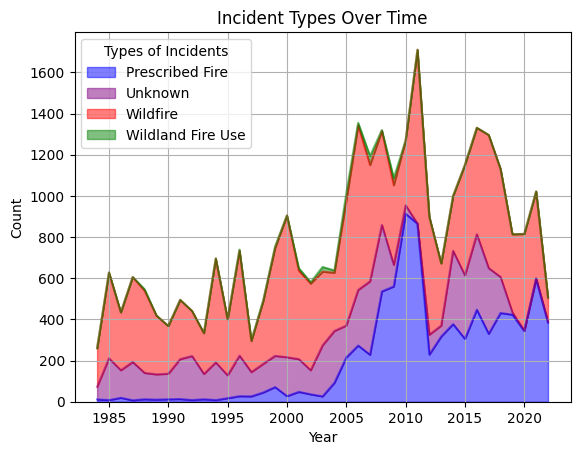

In [12]:
grouped = fire_gdf.groupby(['Year', 'Incid_Type']).size().reset_index(name='Counts')

pivot_table = grouped.pivot(index='Year', columns='Incid_Type', values='Counts').fillna(0)

plt.figure(figsize=(12, 8))
pivot_table.plot(kind='area', stacked=True, alpha=0.5, color=color_fires)
plt.title('Incident Types Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Types of Incidents')
plt.grid(True)
plt.show()

So why are there more prescribed fires now than before? The United States has started trying to take a more proactive approach to wildfires by initiating prescribed fires in the hopes that they can mitigate the damage caused by unplanned wildfires. With climate change causing more and more of an issue with drier climates creating more risk of fire, the U.S. has tried to meet this issue head on.

It still interested me as many sources report a large uptick in the number of forest fires especially since before 2004, but here we see that that increase is largely due to the number of prescribed fires greatly increasing. So now I wanted to verify if they have indeed been making things safer.

<Figure size 1200x800 with 0 Axes>

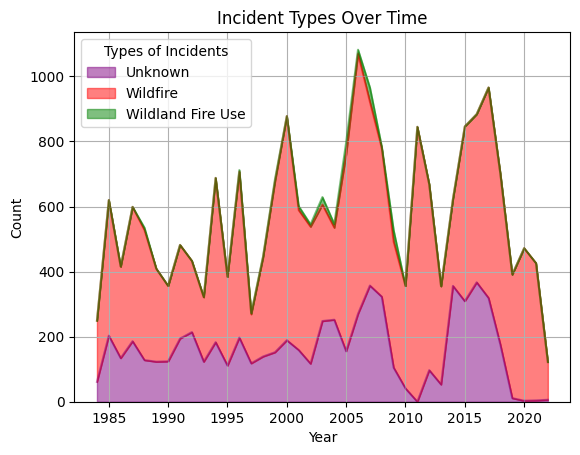

In [13]:
wildfire_gdf = fire_gdf[fire_gdf['Incid_Type'] != 'Prescribed Fire']

grouped = wildfire_gdf.groupby(['Year', 'Incid_Type']).size().reset_index(name='Counts')

pivot_table = grouped.pivot(index='Year', columns='Incid_Type', values='Counts').fillna(0)

plt.figure(figsize=(12, 8))
pivot_table.plot(kind='area', stacked=True, alpha=0.5, color=color_fires)
plt.title('Incident Types Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Types of Incidents')
plt.grid(True)
plt.show()

From the graph, we can't really see that there has been much of an impact on the number of fires being decreased, so what about plotting the average severity of fires now.

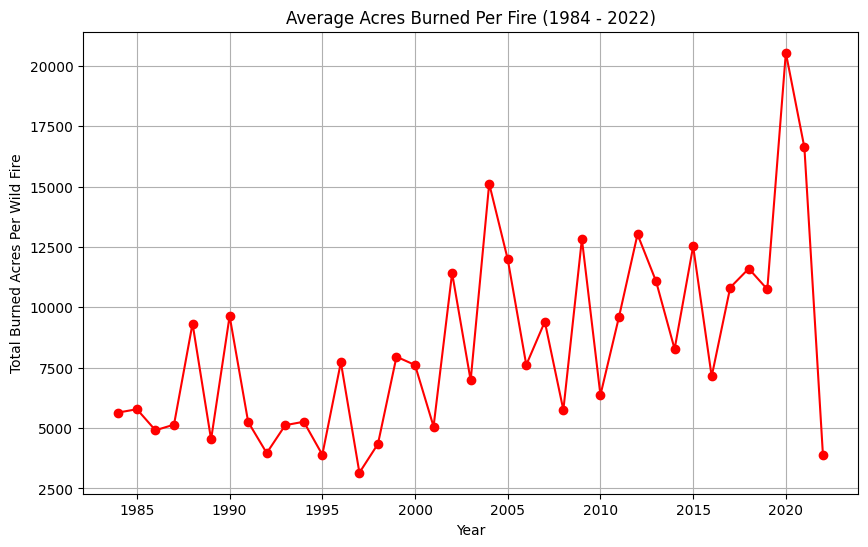

In [14]:
yearly_burned_acres = wildfire_gdf.groupby('Year')['BurnBndAc'].sum()

yearly_fires = wildfire_gdf.groupby('Year')['Event_ID'].count()

average_acreage = yearly_burned_acres / yearly_fires

plt.figure(figsize=(10, 6))
average_acreage.plot(kind='line', marker='o', linestyle='-', color='red')
plt.title('Average Acres Burned Per Fire (1984 - 2022)')
plt.xlabel('Year')
plt.ylabel('Total Burned Acres Per Wild Fire')
plt.grid(True)
plt.show()

In [15]:
average_acreage = average_acreage.reset_index()

average_acreage.columns = ['Year', 'Average Burn Severity']

From looking at the data, there doesn't look to be much of a difference, but let's try with a simple ordinary least squares regression model to look at at whether there actually is statistical significance or not.

In [16]:
import statsmodels.api as sm

In [20]:
since_2004 = average_acreage[average_acreage['Year'] >= 2004]

X = since_2004['Year']
y = since_2004['Average Burn Severity']

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Average Burn Severity   R-squared (uncentered):                   0.885
Model:                               OLS   Adj. R-squared (uncentered):              0.879
Method:                    Least Squares   F-statistic:                              138.6
Date:                   Mon, 15 Apr 2024   Prob (F-statistic):                    6.85e-10
Time:                           16:18:31   Log-Likelihood:                         -184.00
No. Observations:                     19   AIC:                                      370.0
Df Residuals:                         18   BIC:                                      370.9
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

c:\Users\Brodie\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  k, _ = kurtosistest(a, axis)


And from here we see that there hasn't been much of an improvement since the introduction of more prescribed fires since 2004. And in fact, there even was a marked increase.

We're going to try to use Interrupted Time Series analysis in order to determine if the implementation of these have worked for the burn severity of the non-prescribed fires.

In [86]:
average_acreage['post_intervention'] = (average_acreage['Year'] > 2003).astype(int)
average_acreage['time_since_intervention'] = np.where(average_acreage['Year'] > 2003, average_acreage['Year'] - 2003, 0)

X = sm.add_constant(average_acreage[['Year', 'post_intervention', 'time_since_intervention']])
y = average_acreage['Average Burn Severity']

X, y

(    const  Year  post_intervention  time_since_intervention
 0     1.0  1984                  0                        0
 1     1.0  1985                  0                        0
 2     1.0  1986                  0                        0
 3     1.0  1987                  0                        0
 4     1.0  1988                  0                        0
 5     1.0  1989                  0                        0
 6     1.0  1990                  0                        0
 7     1.0  1991                  0                        0
 8     1.0  1992                  0                        0
 9     1.0  1993                  0                        0
 10    1.0  1994                  0                        0
 11    1.0  1995                  0                        0
 12    1.0  1996                  0                        0
 13    1.0  1997                  0                        0
 14    1.0  1998                  0                        0
 15    1.0  1999        

In [87]:
model = sm.OLS(y, X).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     Average Burn Severity   R-squared:                       0.376
Model:                               OLS   Adj. R-squared:                  0.322
Method:                    Least Squares   F-statistic:                     7.020
Date:                   Tue, 27 Feb 2024   Prob (F-statistic):           0.000811
Time:                           23:03:37   Log-Likelihood:                -368.47
No. Observations:                     39   AIC:                             744.9
Df Residuals:                         35   BIC:                             751.6
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

From the statistical test above, we can see that there isn't any statistical difference from before the uptick in prescribed fires since 2004. 

We see that the R-Squared is 0.376 which means that 37.6% of the variability in the average burn severity is explained by the model which leaves a lot left to be explained. 

Now the exact parameters on this are pretty much all insignificant but the post_intervention is the closest with a p-value of 0.179. This would suggest no statistical signficance since the start of using prescribed fires.

Now this model isn't bulletproof by any means. The exact rate of how many prescribed fires were used and where would also be a factor in the prediction as well as many other variables such as rise local temperatures, humidity, and other environmental factors to why fires would still be persisting at similar rates.

### State Based EDA

I now just wanted to look at specific data across each state to determine which ones had the most forest fires to determine any trends.

In [88]:
# Just fires for within the continuuous 48 for easier visualization, sorry Alaska and Hawaii
fire_states = gpd.sjoin(fire_gdf, state_gdf, how='inner', op='within')

fire_states

C:\Users\Brodie\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,index_right,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER
1,SD4308410285019840906,None,SANDOZ,Wildfire,4535,MTBS,Initial,2691,43.084,-102.850,...,18,46,01785534,0400000US46,46,SD,South Dakota,00,196342918877,3386737669
2,MT4880411345819840819,None,NAPI PEAK,Wildfire,4536,MTBS,Extended,3680,48.804,-113.458,...,26,30,00767982,0400000US30,30,MT,Montana,00,376973729130,3866634365
3,MT4533610695819840826,None,KIRBY,Wildfire,4537,MTBS,Extended,1597,45.336,-106.958,...,26,30,00767982,0400000US30,30,MT,Montana,00,376973729130,3866634365
4,MT4561710632319840918,None,LAKE CREEK,Wildfire,4538,MTBS,Initial,3617,45.617,-106.323,...,26,30,00767982,0400000US30,30,MT,Montana,00,376973729130,3866634365
5,OK3698209465619840221,None,RESIDENT,Wildfire,4539,MTBS,Initial (SS),1048,36.982,-94.656,...,20,40,01102857,0400000US40,40,OK,Oklahoma,00,177664154114,3373725677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30919,FL2587108124920220306,None,OCHOPEE RX UNIT C (DR311),Prescribed Fire,10024901,MTBS,Initial,2500,25.868,-81.257,...,30,12,00294478,0400000US12,12,FL,Florida,00,138961722096,45972570361
30920,FL3027208471520220201,None,UNNAMED,Prescribed Fire,10024910,MTBS,Initial,1071,30.266,-84.701,...,30,12,00294478,0400000US12,12,FL,Florida,00,138961722096,45972570361
30921,FL3043308448820220301,None,UNNAMED,Prescribed Fire,10024914,MTBS,Initial,2106,30.43,-84.491,...,30,12,00294478,0400000US12,12,FL,Florida,00,138961722096,45972570361
30922,AL3111908654520220504,EDF9CE76-7A31-4BA4-BD95-5DB4BA8605BE,CN BLUE SPRINGS EAST 17,Prescribed Fire,10024915,MTBS,Initial,1887,31.124,-86.547,...,35,01,01779775,0400000US01,01,AL,Alabama,00,131175477769,4591897964


c:\Users\Brodie\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


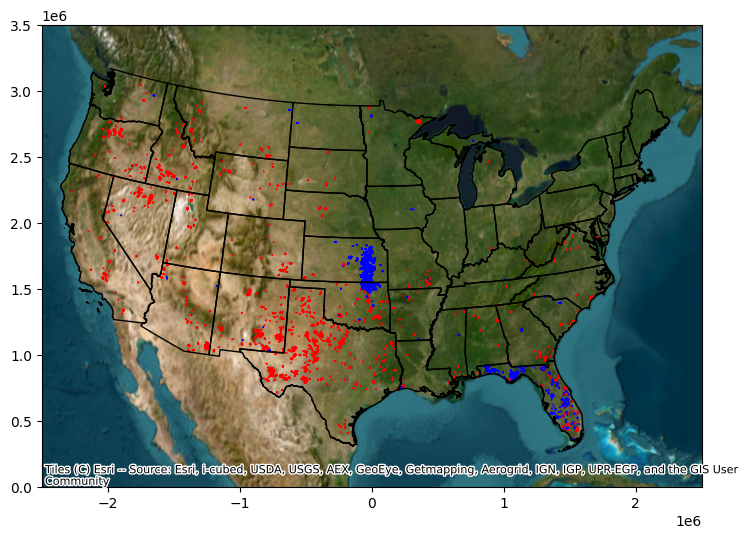

In [89]:
# Function to plot one year at a time

color_fires = {
    'Wildfire': 'red',
    'Prescribed Fire': 'blue',
    'Wildland Fire Use': 'green',
    'Unknown': 'purple'
}

def plot_year(gdf, year):
    gdf2 = gdf[(gdf['Ig_Date'] >= f'{year}-01-01') & (gdf['Ig_Date'] <= f'{year}-12-31')]
    gdf2['color'] = gdf2['Incid_Type'].apply(lambda x: color_fires[x])

    fig, ax = plt.subplots(figsize=(10,6))

    gdf2.plot(ax=ax, alpha=1, facecolor=gdf2['color'], edgecolor=gdf2['color'])
    state_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    
    ctx.add_basemap(ax, crs=gdf2.crs.to_string(), source=ctx.providers.Esri.WorldImagery)

    ax.set_xlim([-2500000, 2500000])
    ax.set_ylim([-00000, 3500000])

    plt.show()

plot_year(fire_states, '2011')

c:\Users\Brodie\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


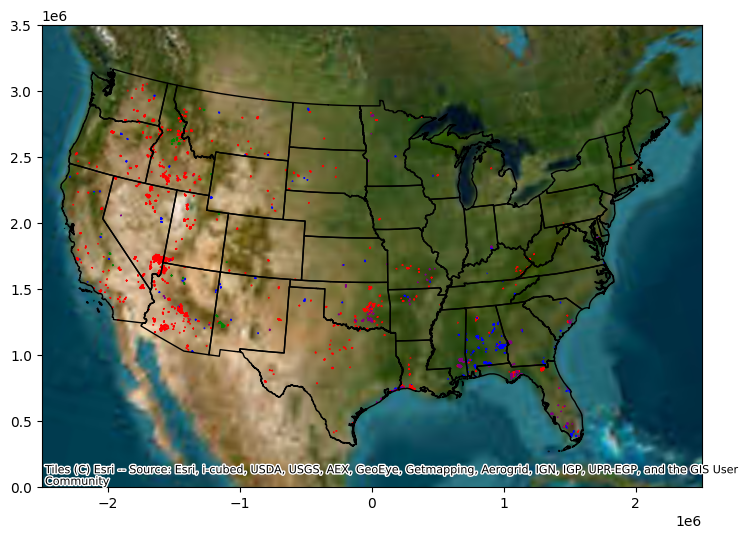

In [90]:
plot_year(fire_gdf, '2005')

In [91]:
# States with the most burned area
burn_by_state = fire_states.groupby('STUSPS')['BurnBndAc'].sum().sort_values(ascending=False)

burn_by_state.head(10)

STUSPS
CA    22921691
ID    16145681
FL    12079084
OR    12042629
NV    11521550
KS     9742034
TX     8743406
MT     8713083
AZ     8344076
WA     7408732
Name: BurnBndAc, dtype: int64

In [92]:
# What about burn area in proportion to area of the land of the state

burn_by_state_m2 = burn_by_state * 4046.86     # 1 Acre = 4046.86 square meters

state_areas = state_gdf.drop_duplicates(subset='STUSPS').set_index('STUSPS')['ALAND']

burned_percentage = (burn_by_state_m2 / state_areas).sort_values(ascending=False)

burned_percent_df = burned_percentage.reset_index()

burned_percent_df.columns=['STUSPS', 'Burn_Area']

Text(0.5, 1.0, 'Total Percentage of Land Area Burned (1984 - 2022)')

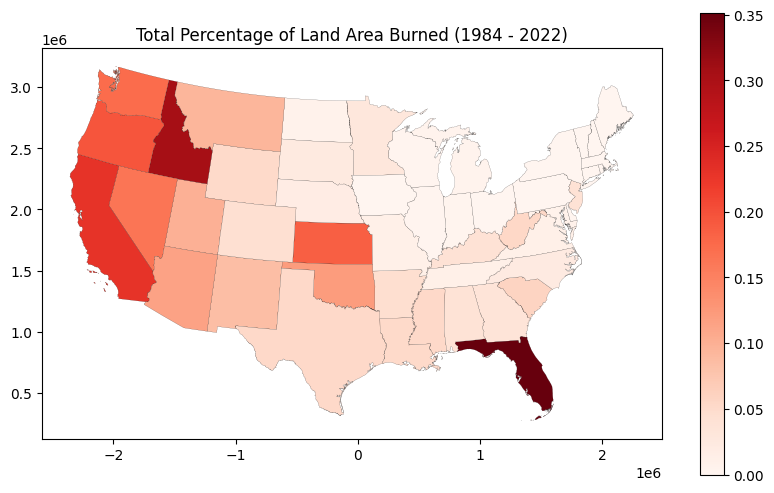

In [93]:
states_burned = state_gdf.copy()
states_burned = states_burned.merge(burned_percent_df, on='STUSPS', how='left')
states_burned['Burn_Area'] = states_burned['Burn_Area'].fillna(0)

fig, ax = plt.subplots(figsize=(10,6))

states_burned.plot(ax=ax, column=states_burned['Burn_Area'], cmap='Reds', edgecolor='black', linewidth=0.1, 
                   legend=True)

ax.set_title('Total Percentage of Land Area Burned (1984 - 2022)')


So why the West Coast (and Florida)? It's largely due to warmer temperatures hitting the coast from the warmer Pacific Ocean. States like California are especially prone to droughts and dry summers leading to better conditions for fires to start and then coastal winds help carry the embers farther. These states also have a large forest cover and can thus supply lots of fuel for the wildfires.

A combination of drier climates, hotter temperatures, and winds can be the perfect melting pot for forest fires. (Haskett)

## Global Forest Cover Trends

This does lead me into my next point however, is that while I originally set out to see if forest fires had an impact on deforestation, that idea was shut down almost immediately due to the fact that the United States has actually seen a growth in forest cover in this time.

In [94]:
global_gdf_file = r"C:\Users\Brodie\Downloads\world-administrative-boundaries\world-administrative-boundaries.shp"

global_gdf = gpd.read_file(global_gdf_file)

global_gdf

,iso3,status,color_code,name,continent,region,iso_3166_1_,french_shor,geometry
0,UGA,Member State,UGA,Uganda,Africa,Eastern Africa,UG,Ouganda,"POLYGON ((33.92110 -1.00194, 33.92027 -1.00111..."
1,UZB,Member State,UZB,Uzbekistan,Asia,Central Asia,UZ,Ouzbékistan,"POLYGON ((70.97081 42.25467, 70.98054 42.26205..."
2,IRL,Member State,IRL,Ireland,Europe,Northern Europe,IE,Irlande,"MULTIPOLYGON (((-9.97014 54.02083, -9.93833 53..."
3,ERI,Member State,ERI,Eritrea,Africa,Eastern Africa,ER,Érythrée,"MULTIPOLYGON (((40.13583 15.75250, 40.12861 15..."
4,None,UK Territory,GBR,South Georgia & the South Sandwich Islands,Antarctica,None,None,South Georgia & the South Sandwich Islands,"MULTIPOLYGON (((-26.24361 -58.49473, -26.24889..."
...,...,...,...,...,...,...,...,...,...
251,BEL,Member State,BEL,Belgium,Europe,Western Europe,BE,Belgique,"POLYGON ((6.01180 50.75727, 6.05472 50.72361, ..."
252,WSM,Member State,WSM,Samoa,Oceania,Polynesia,WS,Samoa,"MULTIPOLYGON (((-171.42920 -14.01625, -171.441..."
253,AIA,UK Non-Self-Governing Territory,AIA,Anguilla,Americas,Caribbean,AI,Anguilla,"POLYGON ((-63.15375 18.16528, -63.16778 18.164..."
254,ISR,Member State,ISR,Israel,Asia,Western Asia,IL,Israël,"POLYGON ((35.62364 33.24573, 35.63249 33.24637..."


In [95]:
# Link:    https://data.worldbank.org/indicator/AG.LND.FRST.ZS?end=2021&start=1990&view=chart
world_bank_file = r"C:\Users\Brodie\Downloads\API_AG.LND.FRST.ZS_DS2_en_csv_v2_123\API_AG.LND.FRST.ZS_DS2_en_csv_v2_123.csv"

world_bank_df = pd.read_csv(world_bank_file, skiprows=4)

world_bank_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,NaN,NaN
1,Africa Eastern and Southern,AFE,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,31.470634,31.260420,31.039682,30.824316,30.611512,30.391626,30.174253,29.955194,NaN,NaN
2,Afghanistan,AFG,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,NaN,NaN
3,Africa Western and Central,AFW,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,20.322187,20.234231,20.152610,20.071327,19.986100,19.901215,19.816777,19.732037,NaN,NaN
4,Angola,AGO,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,56.098301,55.653076,55.207845,54.762629,54.317406,53.872175,53.426951,52.981722,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,"Yemen, Rep.",YEM,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,NaN,NaN
263,South Africa,ZAF,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,14.235127,14.205121,14.175115,14.145109,14.115103,14.085097,14.055091,14.025085,NaN,NaN
264,Zambia,ZMB,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,61.802392,61.549254,61.295955,61.042885,60.789707,60.536515,60.283337,60.030150,NaN,NaN


In [96]:
globe_gdf = gpd.GeoDataFrame(pd.merge(world_bank_df, global_gdf, left_on='Country Code', right_on='iso3', how='inner'))

globe_gdf

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,Unnamed: 67,iso3,status,color_code,name,continent,region,iso_3166_1_,french_shor,geometry
0,Aruba,ABW,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,ABW,NL Territory,ABW,Aruba,Americas,Caribbean,AW,Aruba,"POLYGON ((-69.87486 12.41528, -69.88224 12.411..."
1,Afghanistan,AFG,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,AFG,Member State,AFG,Afghanistan,Asia,Southern Asia,AF,Afghanistan,"POLYGON ((74.91574 37.23733, 74.80873 37.22423..."
2,Angola,AGO,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,AGO,Member State,AGO,Angola,Africa,Middle Africa,AO,Angola,"MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -..."
3,Albania,ALB,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,ALB,Member State,ALB,Albania,Europe,Southern Europe,AL,Albanie,"POLYGON ((20.07142 42.56091, 20.10208 42.53347..."
4,Andorra,AND,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,AND,Member State,AND,Andorra,Europe,Southern Europe,AD,Andorre,"POLYGON ((1.72361 42.50944, 1.71889 42.50305, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,Samoa,WSM,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,WSM,Member State,WSM,Samoa,Oceania,Polynesia,WS,Samoa,"MULTIPOLYGON (((-171.42920 -14.01625, -171.441..."
209,"Yemen, Rep.",YEM,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,YEM,Member State,YEM,Yemen,Asia,Western Asia,YE,Yémen,"MULTIPOLYGON (((52.23416 12.20111, 52.27888 12..."
210,South Africa,ZAF,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,ZAF,Member State,ZAF,South Africa,Africa,Southern Africa,ZA,Afrique du Sud,"POLYGON ((31.29750 -22.41476, 31.30292 -22.424..."
211,Zambia,ZMB,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,ZMB,Member State,ZMB,Zambia,Africa,Eastern Africa,ZM,Zambie,"POLYGON ((32.94040 -9.40508, 32.93944 -9.41583..."


Text(0.5, 1.0, 'Total Percentage of Forest Area in 1992')

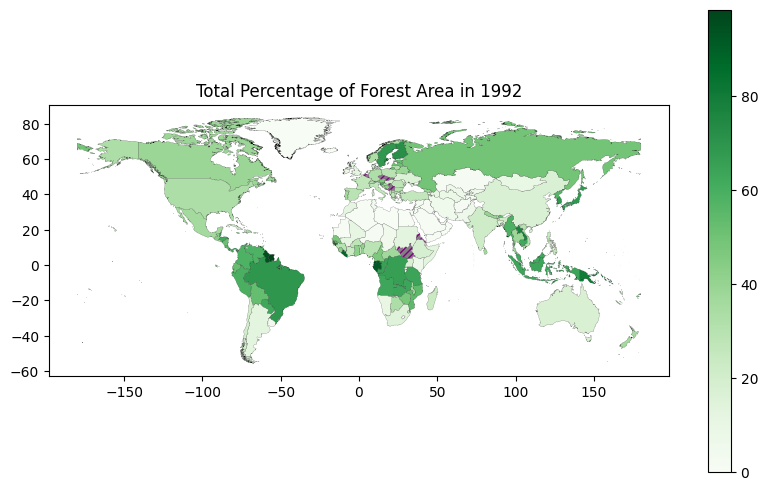

In [97]:
fig, ax = plt.subplots(figsize=(10,6))

missing_style = {
    'color': 'grey',
    'hatch': '/////',
    'edgecolor': 'purple', # So it can be seen against a red and blue map easier
}

globe_gdf.plot(ax=ax, column=globe_gdf['1992'], cmap='Greens', edgecolor='black', linewidth=0.1, 
                   legend=True, missing_kwds=missing_style)

ax.set_title('Total Percentage of Forest Area in 1992')

Text(0.5, 1.0, 'Total Percentage of Forest Area in 2021')

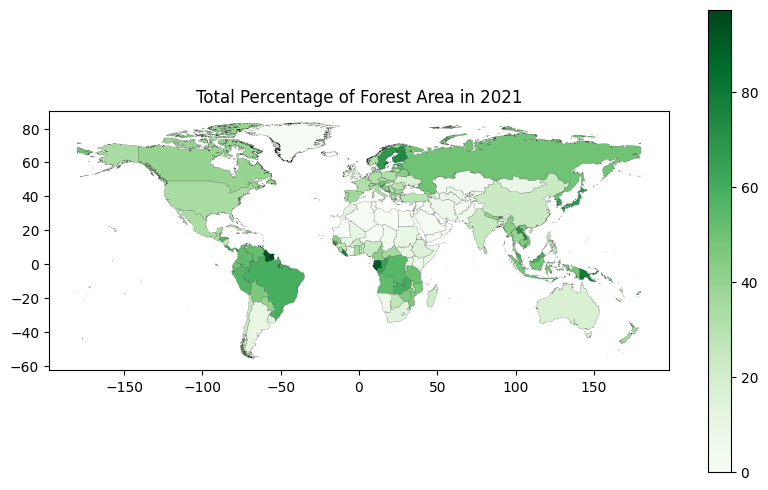

In [98]:
fig, ax = plt.subplots(figsize=(10,6))

globe_gdf.plot(ax=ax, column=globe_gdf['2021'], cmap='Greens', edgecolor='black', linewidth=0.1, 
                   legend=True, missing_kwds=missing_style)

ax.set_title('Total Percentage of Forest Area in 2021')

While it's hard to see from just the graph, there's still a large part of the globe that has seen rises in forestry and tree cover.

Text(0.5, 1.0, 'Percent Difference in Forest Area between 2021 and 1992')

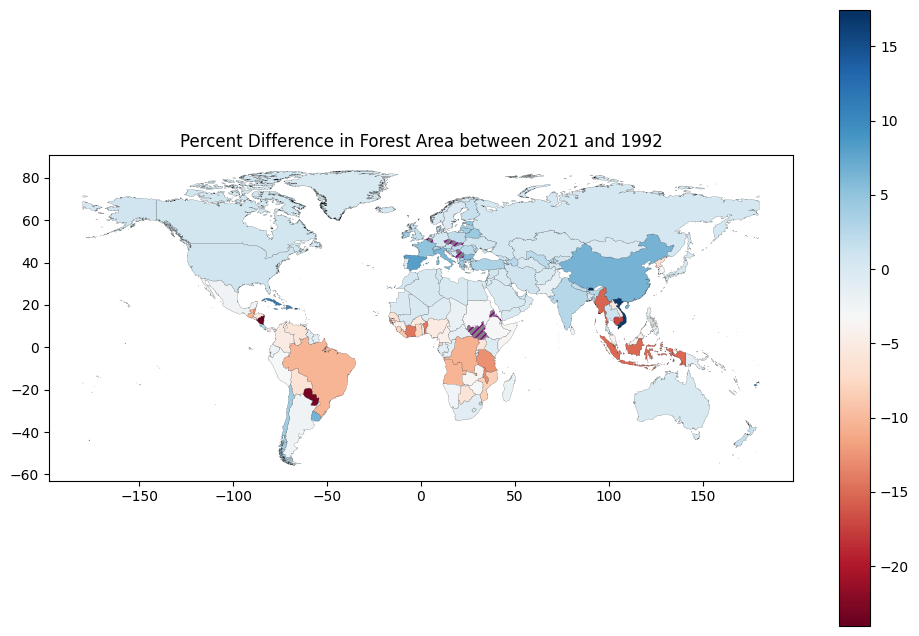

In [99]:
globe_gdf['difference'] = globe_gdf['2021'] - globe_gdf['1992']

fig, ax = plt.subplots(figsize=(12,8))

globe_gdf.plot(ax=ax, column=globe_gdf['difference'], cmap='RdBu', edgecolor='black', linewidth=0.1, 
                   legend=True, missing_kwds=missing_style)

ax.set_title('Percent Difference in Forest Area between 2021 and 1992')

So why do we see so much deforestation in countries in the global south such as Brazil, Tanzania, and Myanmar? Well for quite a few complicated reasons. These types of countries are largely motivated by economic and political factors. 

Many of these countries are trying to catch up economically with the rest of the world so they will cut down trees to expand agriculture or other industries, they'll use the logs as exports to wealthier nations, and the land gained can offer new opportunities for economic development. The world economy stops for no one and many of these countries have deemed it more important to focus on the wellbeing of their people in the short term rather than the long term. (Brockhaus)

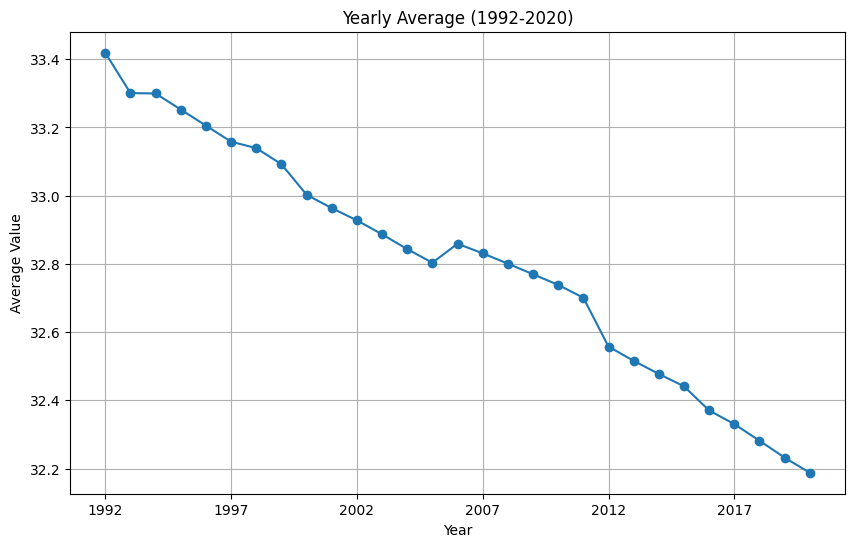

In [100]:
# World average over time
years = [str(year) for year in range(1992, 2021)]
df_years = globe_gdf[years]

yearly_average = df_years.mean()

plt.figure(figsize=(10, 6))
yearly_average.plot(marker='o', linestyle='-')
plt.title('Yearly Average (1992-2020)')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.grid(True)
plt.show()

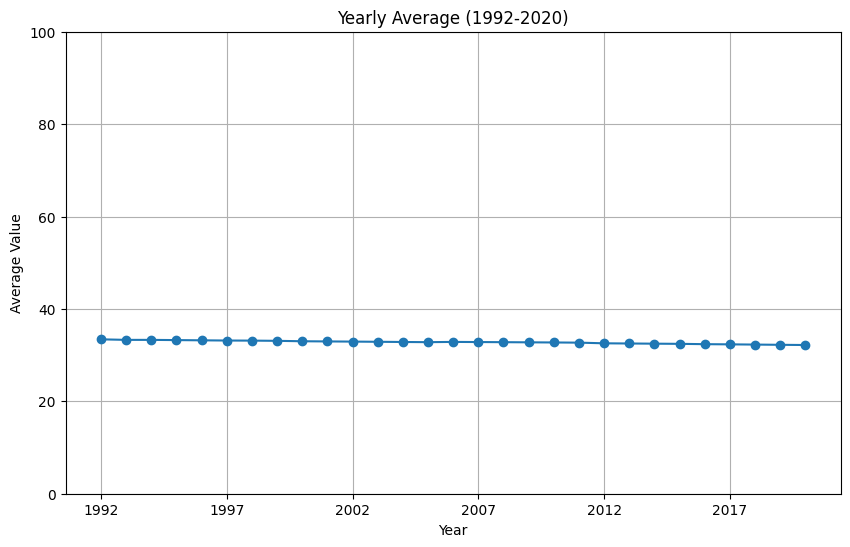

In [101]:
# With y-axis to scale

plt.figure(figsize=(10, 6))
yearly_average.plot(marker='o', linestyle='-')
plt.title('Yearly Average (1992-2020)')
plt.xlabel('Year')
plt.ylim(0,100)
plt.ylabel('Average Value')
plt.grid(True)
plt.show()

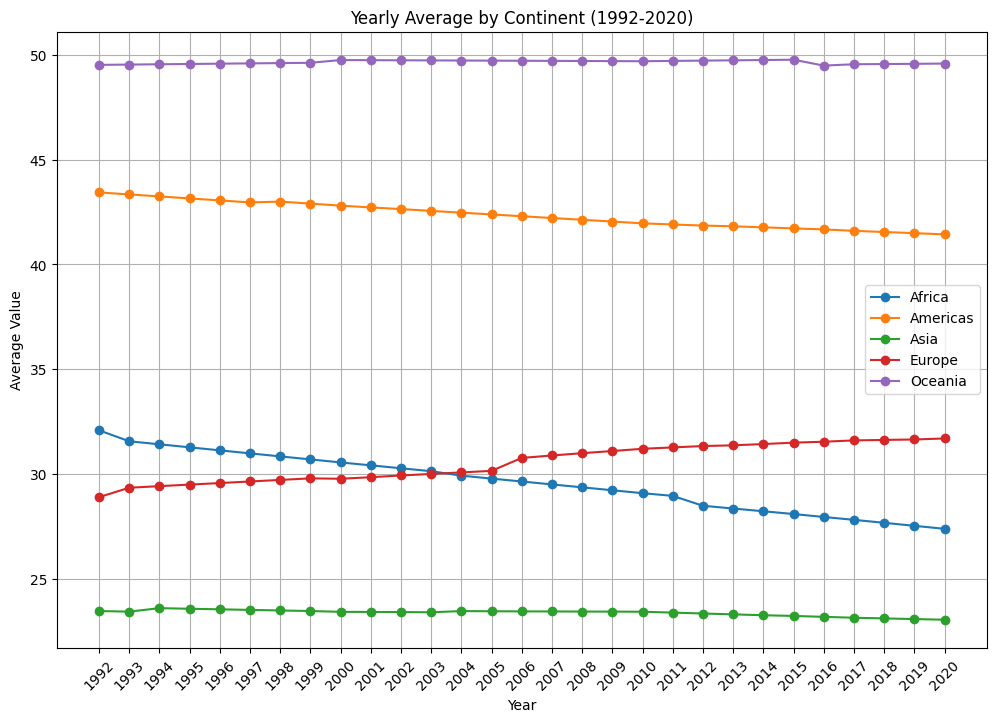

In [102]:
continents = globe_gdf.groupby('continent')

plt.figure(figsize=(12, 8))

for name, group in continents:
    years = [str(year) for year in range(1992, 2021)]
    df_years = group[years]

    yearly_average = df_years.mean()
    
    plt.plot(yearly_average.index, yearly_average, marker='o', linestyle='-', label=name)

plt.title('Yearly Average by Continent (1992-2020)')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.xticks(yearly_average.index, rotation=45)
plt.legend()
plt.grid(True)
plt.show()

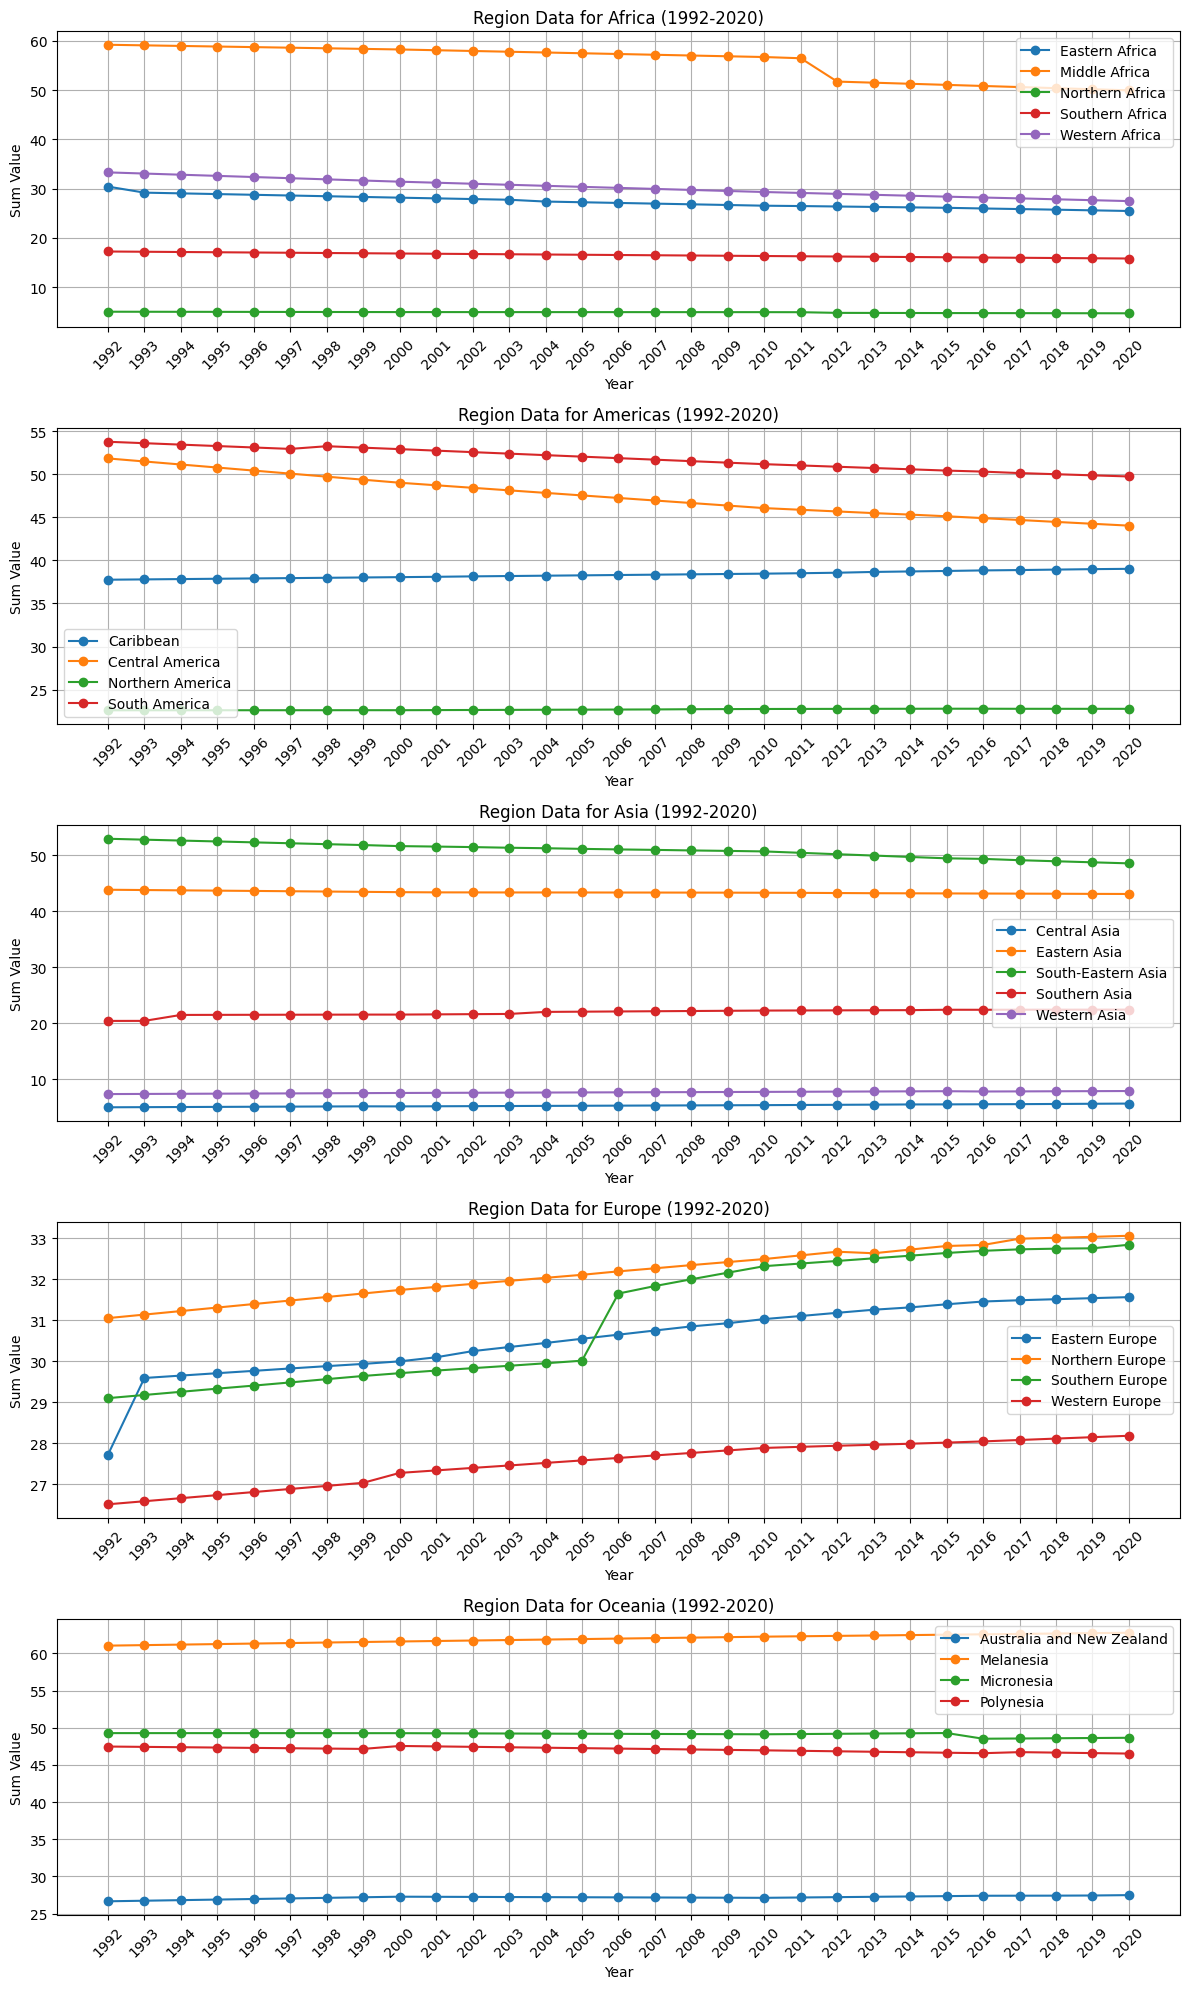

In [103]:
num_continents = len(continents)
fig, axs = plt.subplots(num_continents, 1, figsize=(12, 4 * num_continents))

for ax, (continent, continent_group) in zip(axs, continents):
    regions = continent_group.groupby('region')
    
    for region_name, region_group in regions:
        years = [str(year) for year in range(1992, 2021)]
        df_years = region_group[years]
        
        yearly_mean = df_years.mean()
        
        ax.plot(yearly_mean.index, yearly_mean, marker='o', linestyle='-', label=region_name)
    
    ax.set_title(f'Region Data for {continent} (1992-2020)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Sum Value')

    # For readability
    ax.set_xticks(yearly_mean.index)
    ax.set_xticklabels(yearly_mean.index, rotation=45)
    
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

## Conclusion

While there are certainly issues when it comes to the state of the forests in our world, wildfires do not pose a serious threat to the rate of deforestation in the United States. The recent uptick in forest fires in the United States is largely due to the increase in prescribed fires trying to dampen the damages of unplanned wildfires. Regions all around the world face varying trends in deforestation rates and largely boil down to economic or political reasons with poorer nations typically deforesting for their economic benefit and wellbeing as a nation and richer countries trying to re-forest often to counteract the deforestation they did earlier in their industrialization. 

# Citations

Brockhaus, M., Di Gregorio, M., Djoudi, H. et al. The forest frontier in the Global South: Climate change policies and the promise of development and equity. Ambio 50, 2238–2255 (2021). https://doi.org/10.1007/s13280-021-01602-1

Haskett, Jonathan D., and Anne A. Riddle. Is Climate Change Influencing Wildfires? : Climate Change Effects on Wildfires in the United States. [Library of Congress public edition]., Congressional Research Service, 2023.